# Pipeline for Regression Competition

In [1]:
# Standard library
import os
import itertools

# Data libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# My modules to resume coding
import dhelper, vhelper

# Models libraries
import sklearn
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

# Progress visualization
from tqdm import tqdm

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# To make this notebook's output identical at every run
np.random.seed(0)

%matplotlib inline

In [2]:
# Change this constants for another table
DATASET_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
DATASET_PATH = os.path.join("datasets")

target_col = "median_house_value"

In [3]:
dhelper.fetch_data(DATASET_URL, DATASET_PATH)
df = dhelper.load_data(DATASET_PATH)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
num_cols = [i for i in df.columns if df[i].dtypes == np.number]
cat_cols = [i for i in df.columns if df[i].dtypes != np.number]
nan_cols = [i for i in df.columns if df[i].isnull().any()]
nan_cols

['total_bedrooms']

In [7]:
df['total_bedrooms'].median

<bound method Series.median of 0         129.0
1        1106.0
2         190.0
3         235.0
4         280.0
          ...  
20635     374.0
20636     150.0
20637     485.0
20638     409.0
20639     616.0
Name: total_bedrooms, Length: 20640, dtype: float64>

In [8]:
# if nan_cols:
#     df = dhelper.smart_imputer(df, target_col)

/home/leo/Yandex.Disk/GitHub/competitions/pipelines/regression/dhelper.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[nan_col][df[nan_col].isnull()] = pred


In [21]:
nan_cols

['total_bedrooms']

In [9]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Plotting the distribution of numerical variables.

Saving figure attribute_histogram_plots


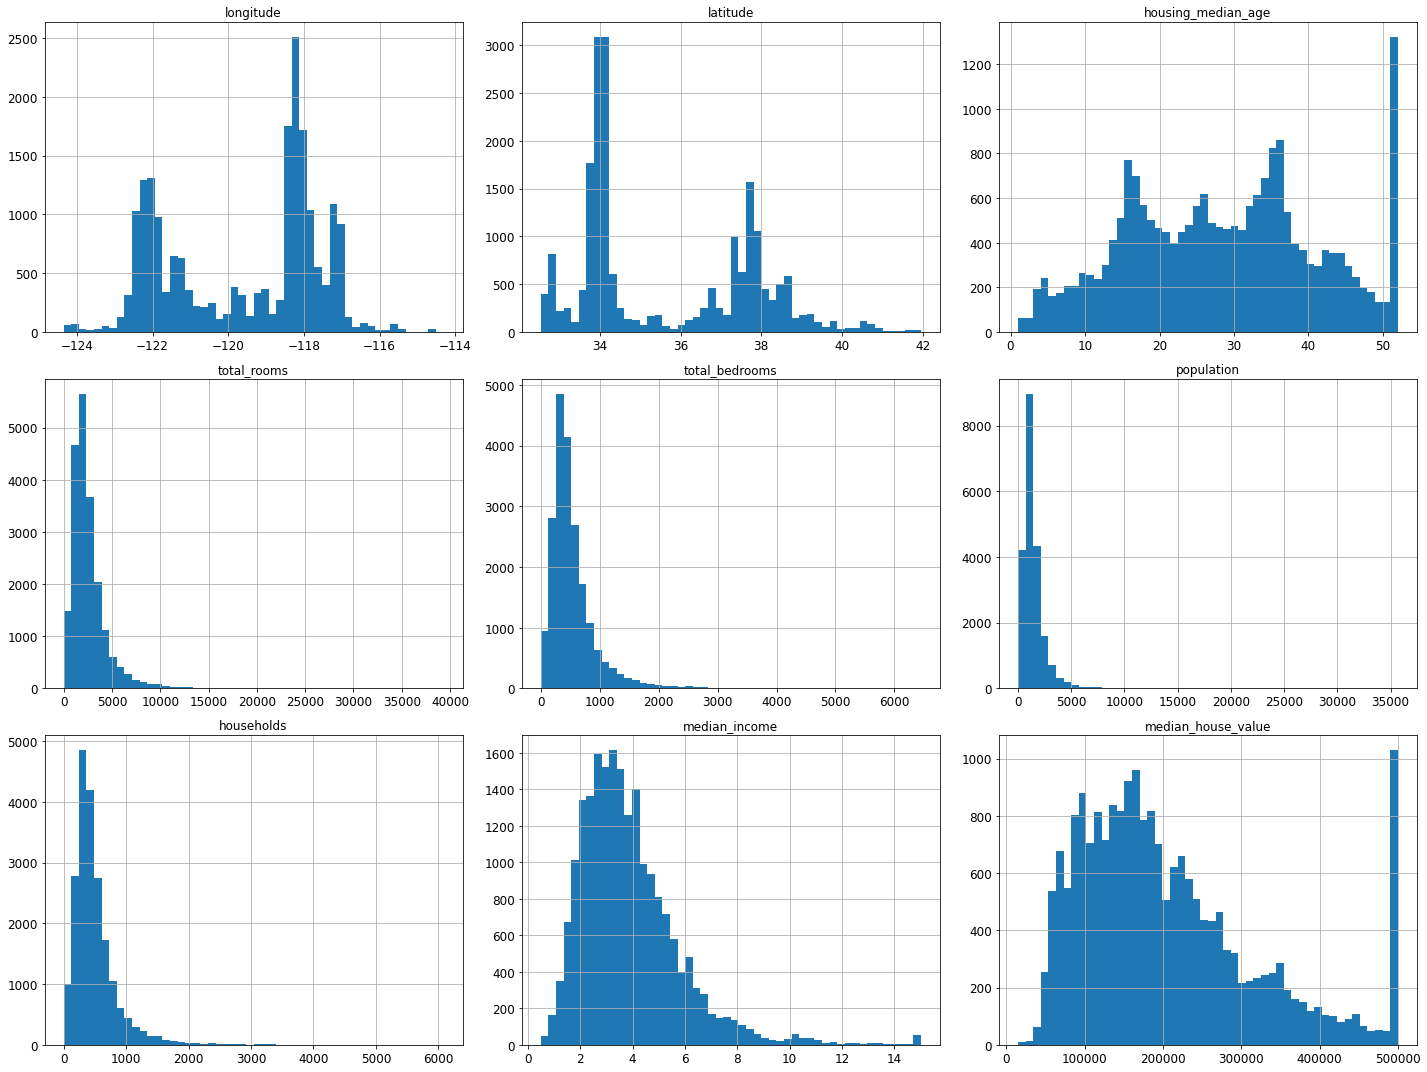

In [10]:
df.hist(bins=50, figsize=(20,15))
vhelper.save_fig("attribute_histogram_plots")
plt.show()

# Discover and visualize geodata

Saving figure housing_prices_scatterplot


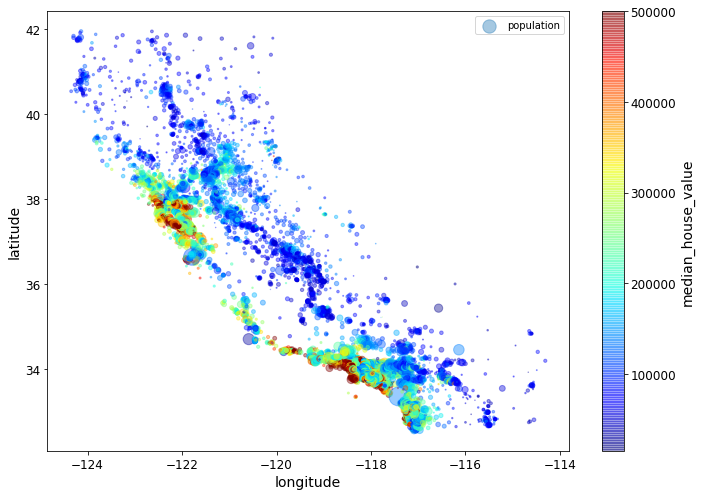

In [11]:
df.plot(kind="scatter",
        x="longitude", y="latitude",
        alpha=0.4,
        s=df["population"]/100,
        label="population",
        figsize=(10,7),
        c="median_house_value",
        cmap=plt.get_cmap("jet"),
        colorbar=True,
        sharex=False);

plt.legend();
vhelper.save_fig("housing_prices_scatterplot")

# Correlation of variables

Now let's determine how the data correlates with the target variable.

In [12]:
target_name = "median_house_value"
corr_matrix = df.corr()
corr_matrix[target_name].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.050542
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [13]:
# attributes = abs(corr_matrix[target_name]).sort_values(ascending=False)[0:4].index
# scatter_matrix(df[attributes], figsize=(12, 8))
# save_fig("scatter_matrix_plot")

Let's take pairs of features and check if there is a linear correlation between the target variable and the interacting attributes.

In [14]:
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols = numeric_cols.drop([target_col])
X = df[numeric_cols]
y = df[target_col]

Let's find correlations.

In [15]:
d = dhelper.make_transformations(X)

/home/leo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
%%time

total = pd.concat([d[key] for key in d], axis=1).dropna(axis=1, how='all')
basic_columns = total.columns

composition = []
coefficient = []
df_c = pd.DataFrame({'composition':[],
                     'coefficient':[]})


def find_good_compositions(df_c, num):
    '''Find compositions with good correlation coefficients
    for num of attributes '''
        
    for c in tqdm(set(itertools.combinations(basic_columns, num))):
        x = np.ones(total.shape[0])
        for i in range(num):
            x *= total[c[i]]
        cc = abs(np.corrcoef(x, y)[0, 1])
        if cc > 0.1:
            composition.append(' * '.join(c))
            coefficient.append(cc)
    return pd.concat([df_c, pd.DataFrame({'composition':composition,
                                         'coefficient':coefficient})], axis=0)

if not os.path.exists('df_c.csv'):
    df_c = find_good_compositions(df_c, 2)
    df_c = find_good_compositions(df_c, 3)
    df_c = df_c.sort_values(by='coefficient', ascending=False)
    df_c.to_csv('df_c.csv')
else:
    df_c = pd.read_csv('df_c.csv', index_col=0)

CPU times: user 59 ms, sys: 20.4 ms, total: 79.3 ms
Wall time: 78.3 ms


In [17]:
best_combinations = dhelper.find_best_compositions(df, df_c)

  0%|          | 0/42775 [00:00<?, ?it/s]

households * median_income * 1/population 0.7456280675159189


 22%|██▏       | 9499/42775 [00:02<00:10, 3227.19it/s]

longitude * 1/log(latitude) * 1/tanh(log(latitude)) 0.491089117951708


 41%|████      | 17327/42775 [00:05<00:07, 3358.82it/s]

housing_median_age * total_rooms * housing_median_age**0.5 0.2740916115756237


100%|██████████| 42775/42775 [00:12<00:00, 3335.82it/s]


In [18]:
composite_features = dict()
for combination in best_combinations:
    cols = combination.split(' * ')
    x = np.ones(total.shape[0])
    for col in cols:
        x *= total[col]
    composite_features[combination] = x

composite_features = pd.DataFrame(composite_features)

# Modeling

With composite features

In [19]:
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(pd.concat([df.drop([target_name], axis=1), composite_features], axis=1),
                                                    y, test_size = 0.2, random_state=42)

model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=10,
                          cat_features=['ocean_proximity'])
model.fit(X_train, y_train, verbose_eval=False)

y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

28610.9515687019


План:
- Упростить процедуру представления данных
- Проверка на мультиколинеарность соответствующих признаков между собой

# Source for start ideas
- https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb